<div align="right">
Massimo Nocentini
<br>
<small>
<br>September 15, 2016: promoted as tutorial, doc
<br>September 14, 2016: refactoring, nodes zooming
<br>September 13, 2016: loading and storing big graphs as JSON streams
<br>September 9, 2016: asynchronous fetching, cleaning
<br>September 8, 2016: synchronous fetching, drawing
</small>
</div>

<br>
<div align="center">
<b>Abstract</b><br>
This document describes our effort to perform mining techniques on the [OEIS][oeis].
</div>

[oeis]:http://oeis.org

**Imports**

The following cell import the function `oeis_search` in order to query the *Online Encyclopedia of Integer Sequences* and render search results directly in the current notebook; for a detailed tutorial, see http://nbviewer.jupyter.org/github/massimo-nocentini/competitive-programming/blob/master/tutorials/oeis-interaction.ipynb?flush_cache=true

In [1]:
import oeis

on the other hand, for develop sessions:

In [14]:
%run ../python-libs/oeis.py

---

`matplotlib` plotting stuff:

In [11]:
%matplotlib inline

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 20, 20

# Analysis

   - A link to the official documentation with many graph algorithms provided by `networkx` module: https://networkx.readthedocs.io/en/stable/reference/algorithms.html
   - A link to the drawing algorithm behind `spring_layout`: https://en.wikipedia.org/wiki/Force-directed_graph_drawing#cite_note-1

# Use cases

In [3]:
fibonacci_seq_id, catalan_seq_id = 45, 108

## Fibonacci numbers 

In [63]:
searchable = oeis_search(id=fibonacci_seq_id)

*

In [64]:
searchable(data_only=True)

_Results for query: <a href='https://oeis.org/search?fmt=json&q=id%3AA000045&start=0'>https://oeis.org/search?fmt=json&q=id%3AA000045&start=0</a>_<br><hr><div align='center'><b><a href='http://oeis.org/A000045'>A000045</a></b>: <i>Fibonacci numbers: F(n) = F(n-1) + F(n-2) with F(0) = 0 and F(1) = 1.</i><br></div>

by _N. J. A. Sloane_, 1964

_Keywords_: `core,nonn,nice,easy,hear,changed`

_Data_:

$$
\begin{array}{c|ccccccccccccccc}
n & 0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 & 10 & 11 & 12 & 13 & 14 \\
\hline
A000045(n) & 0 & 1 & 1 & 2 & 3 & 5 & 8 & 13 & 21 & 34 & 55 & 89 & 144 & 233 & 377
\end{array}
$$


### Whole representation

In [13]:
%%time
fib_graph = oeis_graph(seq_id=fibonacci_seq_id, depth=2, workers=30)


Fringe at distance 0, 1 sequences to fetch.
*
Fringe at distance 1, 70 sequences to fetch.
**********************************************************************
Fringe at distance 2, 384 sequences to fetch.
************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************
Horizon reached.
CPU times: user 55.4 s, sys: 4.22 s, total: 59.6 s
Wall time: 30.9 s


In [42]:
G_fibonacci = make_nx_graph(fib_graph)#, node_remp=lambda n, G: G.out_degree(n) > 2)

A graph with 455 nodes and 2193 edges will be drawn


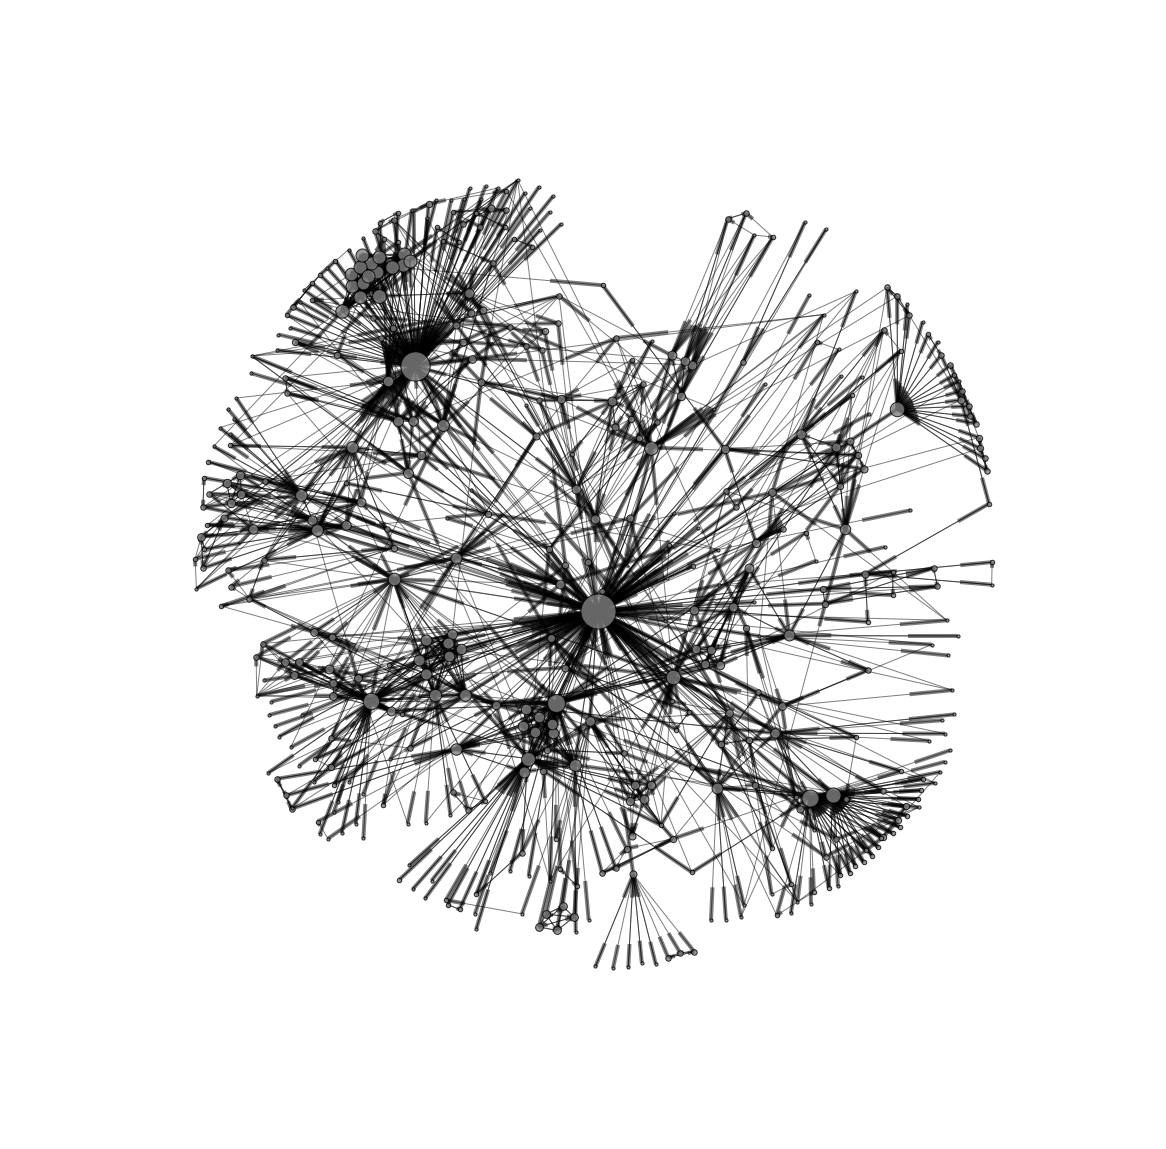

In [44]:
draw_nx_graph(G_fibonacci, 
              nodes_labels={'draw':False, fibonacci_seq_id:r'$\alpha$', catalan_seq_id:r'$\beta$'})

### Dominating set

In [47]:
dom_set = nx.dominating_set(G_fibonacci, start_with=fibonacci_seq_id)

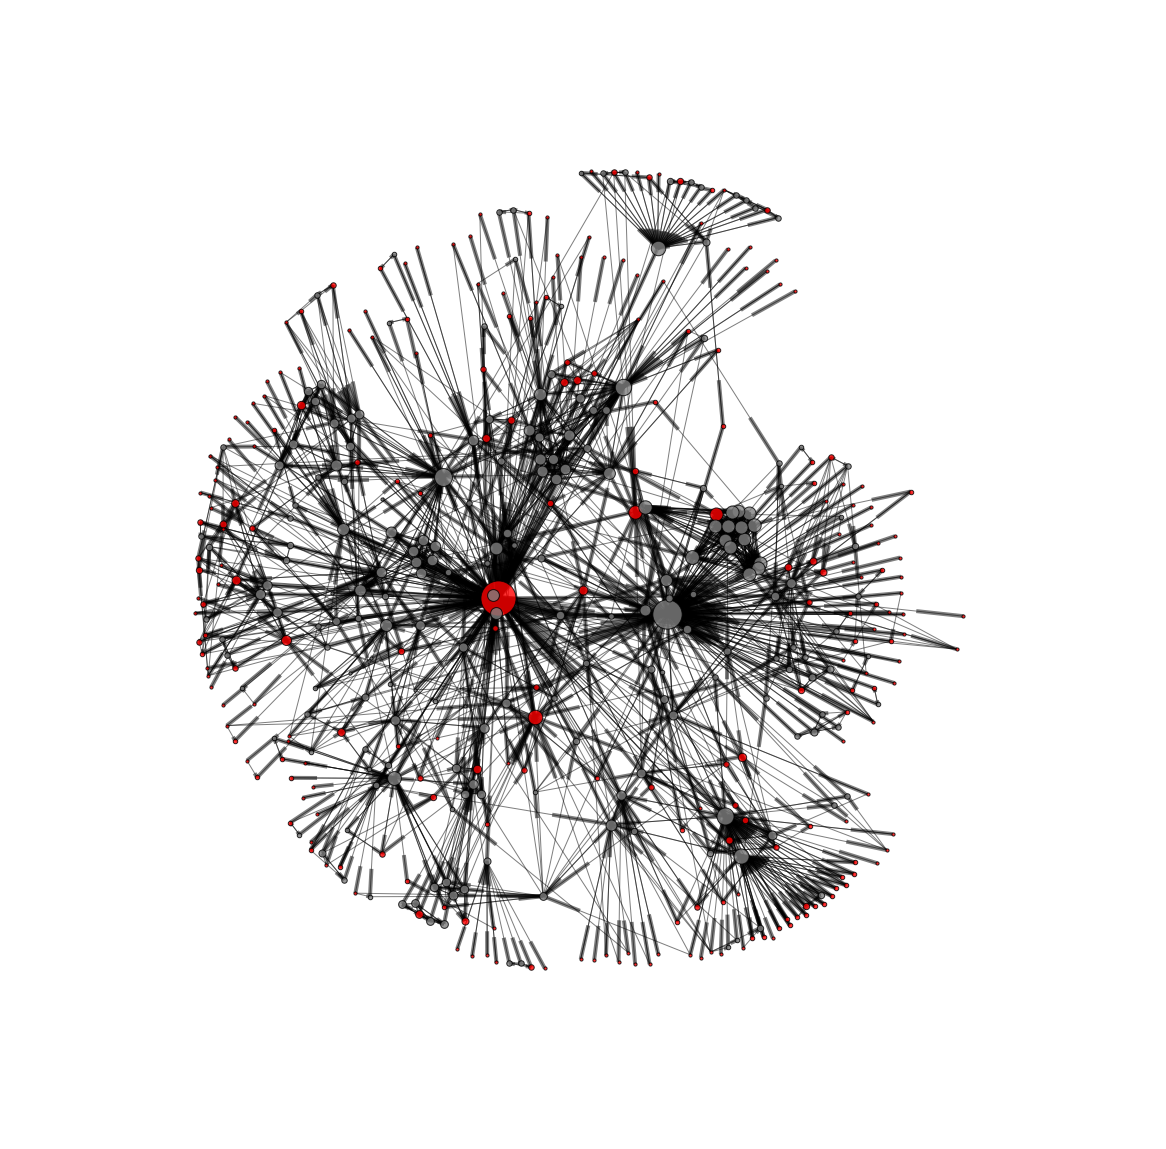

In [48]:
draw_nx_graph(G_fibonacci, 
              nodes_colors={n:'r' for n in dom_set},
              nodes_labels={'draw':False, fibonacci_seq_id:r'$\alpha$', catalan_seq_id:r'$\beta$'})

### Loading big graph

In [54]:
fib_graph = load_graph(filename='../python-libs/fibonacci.json')

In [57]:
G_fibonacci = make_nx_graph(fib_graph, digraph=False, 
                           node_remp=lambda n, G: 'nice' not in fib_graph[n]['keyword'])

A graph with 396 nodes and 929 edges will be drawn


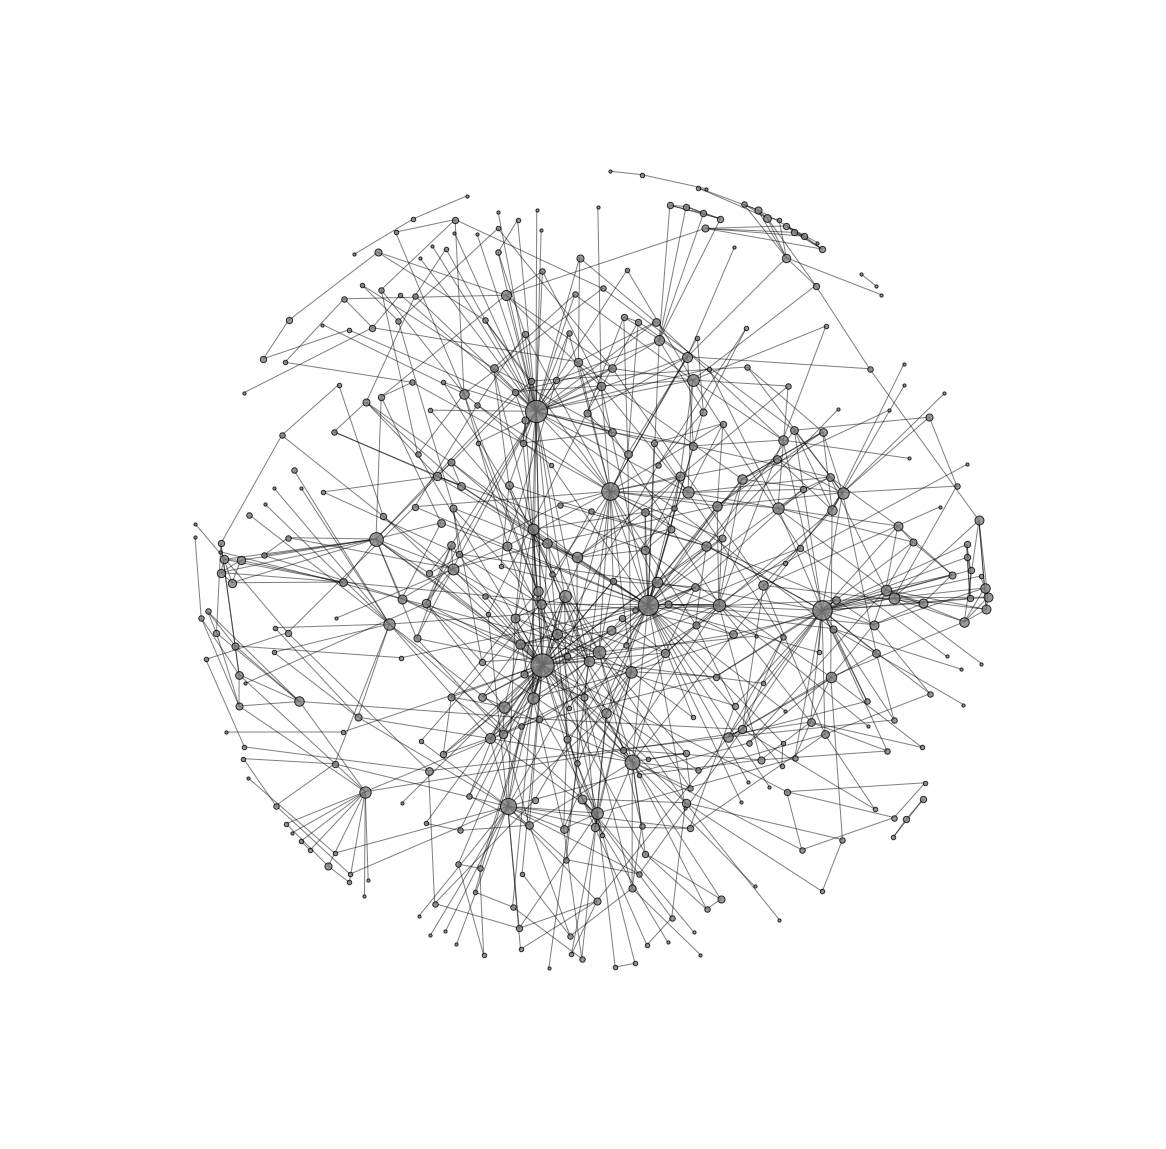

In [58]:
draw_nx_graph(G_fibonacci, nodes_labels={'draw':False})

## Catalan numbers

In [4]:
searchable = oeis_search(id=catalan_seq_id)

*

In [5]:
searchable(data_only=True)

_Results for query: <a href='https://oeis.org/search?q=id%3AA000108&fmt=json&start=0'>https://oeis.org/search?q=id%3AA000108&fmt=json&start=0</a>_<br><hr><div align='center'><b><a href='http://oeis.org/A000108'>A000108</a></b>: <i>Catalan numbers: C(n) = binomial(2n,n)/(n+1) = (2n)!/(n!(n+1)!). Also called Segner numbers.</i><br></div>

by _N. J. A. Sloane_

_Keywords_: `core,nonn,easy,eigen,nice,changed`

_Data_:

$$
\begin{array}{c|ccccccccccccccc}
n & 0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 & 10 & 11 & 12 & 13 & 14 \\
\hline
A000108(n) & 1 & 1 & 2 & 5 & 14 & 42 & 132 & 429 & 1430 & 4862 & 16796 & 58786 & 208012 & 742900 & 2674440
\end{array}
$$


In [6]:
catalan_graph = oeis_graph(seq_id=catalan_seq_id, depth=2, workers=30)


Fringe at distance 0, 1 sequences to fetch.
*
Fringe at distance 1, 77 sequences to fetch.
*****************************************************************************
Fringe at distance 2, 317 sequences to fetch.
*****************************************************************************************************************************************************************************************************************************************************************************************************************************
Horizon reached.


In [9]:
G_catalan = make_nx_graph(catalan_graph)

A graph with 395 nodes and 1424 edges will be drawn


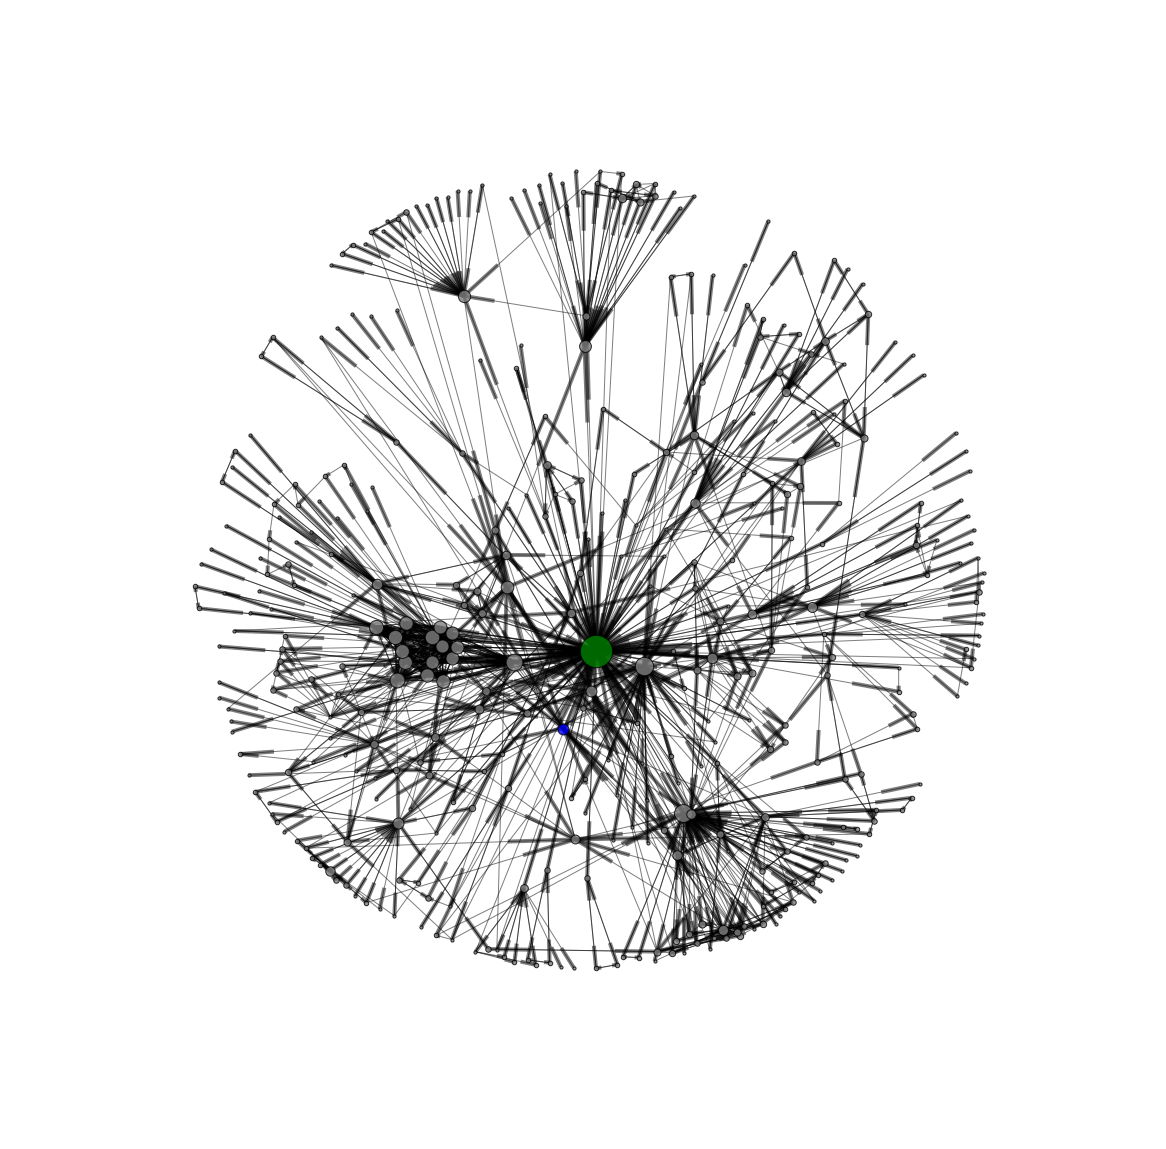

In [15]:
draw_nx_graph(G_catalan, 
              nodes_colors={fibonacci_seq_id:'b', catalan_seq_id:'g'},
              nodes_labels={'draw':False})

# Implementation

In [16]:
from inpututils import python_code

### `oeis_graph` function

In [17]:
python_code(oeis_graph)

```python
def oeis_graph(seq_id, depth=2, workers=20, post_processing=[adjust_crossreferences]):
        
    sink = {}
    unknown = 'unknown'
    
    def fetch(seq_id):

        payload = {"fmt": "json", "q": "id:A{:06d}".format(seq_id)}

        def error_handler(GET_result, exc):
            print("sequence {} needs retry; current GET response text:\n{}\n".format(seq_id, GET_result.text))
            return None

        doc = fetch_payload(payload, json_decoding_error_handler=error_handler)
        return doc['results'].pop() if doc['results'] else unknown


    def not_seen_so_far(ref_seq_id):
        return ref_seq_id not in sink
    
    def recursion(sequences, step):
        
        if step > depth: 
            print("\nHorizon reached.")
            return

        print("\nFringe at distance {}, {} sequences to fetch.".format(step, len(sequences)))

        pool = ThreadPool(workers) # Make the Pool of workers

        # Open the urls in their own threads and return the results
        results = pool.map(lambda seq_id: (seq_id, fetch(seq_id)), sequences)

        #close the pool and wait for the work to finish
        pool.close()
        pool.join()

        cross_sequences = set()
        retry = set() 

        for seq_id, result in results: 
            
            if not result:
                retry.add(seq_id)
                continue

            if result is unknown: continue

            # since `recursion` is called if `seq_id` hasn't been fetched
            sink.update({int(result['number']): result}) 

            # preparing for recursion
            cross_sequences |= cross_references(result['xref']) if 'xref' in result else set()
            
        if retry:
            # sleep for some seconds, then retry
            secs = 3
            print("There are {} sequences to be downloaded again. Sleeping for {} secs than redo.".format(len(retry), secs))
            time.sleep(secs)
            recursion(set(filter(not_seen_so_far, retry)), step)

        recursion(set(filter(not_seen_so_far, cross_sequences)), step+1)
        
    recursion({seq_id}, step=0)
    
    for process in post_processing:
        sink = process(sink)

    return sink

```

### `load_graph` and `fetch_graph` functions

In [18]:
python_code(load_graph, fetch_graph, adjust_crossreferences)

```python
def load_graph(filename):

    with open(filename, 'r') as f:

        graph = {int(k):v for k, v in adjust_crossreferences(json.load(f)).items()}
        return adjust_crossreferences(graph)

def fetch_graph(filename, **kwds): 

    def save(graph):
        with open(filename, 'w') as f:
            json.dump(graph, f)

    start_timestamp = time.time()

    graph = oeis_graph(post_processing=[], **kwds)

    end_timestamp = time.time()

    print("Elapsed time: {:3} secs.".format(end_timestamp - start_timestamp))

    save(graph)

    print("Graph saved.")

def adjust_crossreferences(graph):

    for k, v in graph.items():

        xrefs = cross_references(v['xref']) if 'xref' in v else set()
        v['xref_as_set'] = {xr for xr in xrefs if xr in graph} 

        for ref in v['xref_as_set']:

            referenced = graph[ref]
            if 'referees' not in referenced: referenced['referees'] = set()
            referenced['referees'].add(k)

    return graph

```

### `networkx` graph making and drawing functions

In [19]:
python_code(make_nx_graph, draw_nx_graph)

```python
def make_nx_graph(graph, summary=True, digraph=True, 
                  node_remp=lambda n, G: False, 
                  edge_remp=lambda u, v, G: False):

    G = nx.DiGraph() if digraph else nx.Graph()

    for seq_id, v in graph.items():
        for ref_seq_id in v['xref_as_set']:
            G.add_edge(seq_id, ref_seq_id)

    G.remove_nodes_from([n for n in G.nodes() if node_remp(n, G)])
    G.remove_edges_from([(u, v) for u, v in G.edges() if edge_remp(u, v, G)])
            
    if summary:
        print("A graph with {} nodes and {} edges will be drawn".format(len(G.nodes()),len(G.edges())))
        
    return G

def draw_nx_graph(G, nodes_colors={}, filename=None, nodes_labels={}):
    
    import matplotlib.pyplot as plt

    if 'draw' not in nodes_labels: nodes_labels['draw'] = True
    
    nc = defaultdict(lambda: 'gray')
    nc.update(nodes_colors)
    
    pos=nx.spring_layout(G)#, iterations=200) # positions for all nodes

    degrees = G.in_degree() if G.is_directed() else G.degree()
    for seq_id in G.nodes():
        nx.draw_networkx_nodes(G, pos, nodelist=[seq_id], 
                               node_color=nc[seq_id],
                               node_size=degrees[seq_id]*10, 
                               alpha=0.8)

    """
    nx.draw_networkx_nodes(G,pos,
                           nodelist=set(G.nodes())-set(favorite_nodes.keys()),
                           node_color='r',
                           node_size=500,
                       alpha=0.8)
    """
    
    nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
    
    if nodes_labels['draw']:
        ls = {n:nodes_labels[n] if n in nodes_labels else (str(n) if G.in_degree()[n] > 10 else "") 
              for n in G.nodes()}
        nx.draw_networkx_labels(G,pos,ls,font_size=16)

    plt.axis('off')
    if filename: plt.savefig(filename) # save as png
    else: plt.show()

```

# Sandbox

In [73]:
import re
from requests import get
from itertools import count

## `asyncio`

Before starting coding, we collect an [interesting link][l].

[l]:http://sahandsaba.com/understanding-asyncio-node-js-python-3-4.html

In [3]:
import asyncio

### Simple examples using `event_loop`

Taken from https://docs.python.org/3.5/library/asyncio-eventloop.html#event-loop-examples

In [4]:

def hello_world(loop):
    print('Hello World')
    loop.stop()

loop = asyncio.get_event_loop()

# Schedule a call to hello_world()
loop.call_soon(hello_world, loop)

# Blocking call interrupted by loop.stop()
loop.run_forever()
print("before close")
loop.close()
print("after close")

Hello World
before close
after close


Taken from https://community.nitrous.io/tutorials/asynchronous-programming-with-python-3

In [ ]:

async def download(url, parts):
    async def get_partial_content(u, i, start, end):
        print(i, start, end)
        async with aiohttp.get(
                u, headers={"Range": "bytes={}-{}".format(start, end - 1 if end else "")}) as _resp:
            return i, await _resp.read()

    async with aiohttp.head(url) as resp:
        size = int(resp.headers["Content-Length"])

    ranges = list(range(0, size, size // parts))

    res, _ = await asyncio.wait(
        [get_partial_content(url, i, start, end) for i, (start, end) in
         enumerate(itertools.zip_longest(ranges, ranges[1:], fillvalue=""))])

    sorted_result = sorted(task.result() for task in res)
    return b"".join(data for _, data in sorted_result)


if __name__ == '__main__':
    image_url = "http://files.vladstudio.com/joy/where_tahrs_live/wall/vladstudio_where_tahrs_live_2880x1800_signed.jpg"
    loop = asyncio.get_event_loop()
    bs = loop.run_until_complete(download(image_url, 16))

    with open("test_para_async.jpeg", "wb") as fi:
        fi.write(bs)

### Asynchronous version

In [28]:
async def oeis_graph(seq_id, depth=2):
        
    sink = {}
    
    async def fetch(seq_id):
        print("fetching sequence {}".format(seq_id))
        payload = {"fmt": "json", "q": "id:A{:06d}".format(seq_id)}
        doc_result = get("https://oeis.org/search", params=payload,)
        doc = doc_result.json()
        return doc['results'].pop()

    def cross_references(xref):
        regex = re.compile('(?P<id>A\d{6,6})')
        return {int(r[1:]) for references in xref for r in regex.findall(references)}

    def not_seen_so_far(ref_seq_id):
            return ref_seq_id not in sink
    
    async def recursion(sequences, step):
        
        
            
        #res, _ = await asyncio.wait(
        #[get_partial_content(url, i, start, end) for i, (start, end) in
        # enumerate(itertools.zip_longest(ranges, ranges[1:], fillvalue=""))])

        #sorted_result = sorted(task.result() for task in res)
        #return b"".join(data for _, data in sorted_result)
            
        if step > depth: return sink

        print("\nFetching sequences:\n{} ".format(sequences))
        
        res, _ = await asyncio.wait([fetch(ref_seq_id)
                                     for i, ref_seq_id in zip(count(), sequences)
                                     #if i < 5 # to delete when we arrive at a working prototype
                                    ])
        
        cross_sequences = set()
        
        for task in res: 
            
            result = task.result()
            sink.update({seq_id: result}) # since `recursion` is called if `seq_id` hasn't been fetched

            # preparing for recursion
            result['xref_as_set'] = cross_references(result['xref']) if 'xref' in result else set()
            cross_sequences |= result['xref_as_set']
            
        return await recursion(set(filter(not_seen_so_far, cross_sequences)), step+1)
        
    return await recursion({seq_id}, step=0)
    

In [ ]:
loop = asyncio.get_event_loop()
bs = loop.run_until_complete(oeis_graph(seq_id=45, depth=3))

## Threading version

Our implementation is inspired by the following example, taken from http://stackoverflow.com/questions/2846653/how-to-use-threading-in-python

In [7]:
%%time

import urllib.request
from multiprocessing.dummy import Pool as ThreadPool 

urls = [
  'http://www.python.org', 
  'http://www.python.org/about/',
  'http://www.onlamp.com/pub/a/python/2003/04/17/metaclasses.html',
  'http://www.python.org/doc/',
  'http://www.python.org/download/',
  'http://www.python.org/getit/',
  'http://www.python.org/community/',
  'https://wiki.python.org/moin/',
  ]

# Make the Pool of workers
pool = ThreadPool(4) 

# Open the urls in their own threads
# and return the results
results = pool.map(urllib.request.urlopen, urls)

#close the pool and wait for the work to finish 
pool.close() 
pool.join()


CPU times: user 210 ms, sys: 20 ms, total: 230 ms
Wall time: 1.31 s


In [8]:
results

## Synchronous version

In [7]:
def oeis_graph(seq_id, depth=2):
        
    sink = {}
    
    def recursion(seq_id, step):
        
        payload = {"fmt": "json", "q": "id:A{:06d}".format(seq_id)}
        doc_result = get("https://oeis.org/search", params=payload,)
        doc = doc_result.json()
        result = doc['results'].pop()

        sink.update({seq_id: result})

        # preparing for recursion
        xrefs = result['xref'][:10] if 'xref' in result else []

        cross_references = set()
        regex = re.compile('(?P<id>A\d{6,6})')
        for xref in xrefs:
            cross_references |= set(int(r[1:]) for r in regex.findall(xref))

        result['xref_as_set'] = cross_references
        print("\ncross references of sequence id {}:\n{} ".format(seq_id, cross_references))
            
        if step < depth:
            for i, ref_seq_id in zip(count(), filter(lambda cr: cr not in sink, cross_references)):
                if i > 4: break
                recursion(ref_seq_id, step+1)
        
    recursion(seq_id, step=0)
    
    return sink


---

## `networkx` example

Taken from the [official documentation][example].

[example]:https://networkx.github.io/documentation/networkx-1.10/examples/drawing/labels_and_colors.html

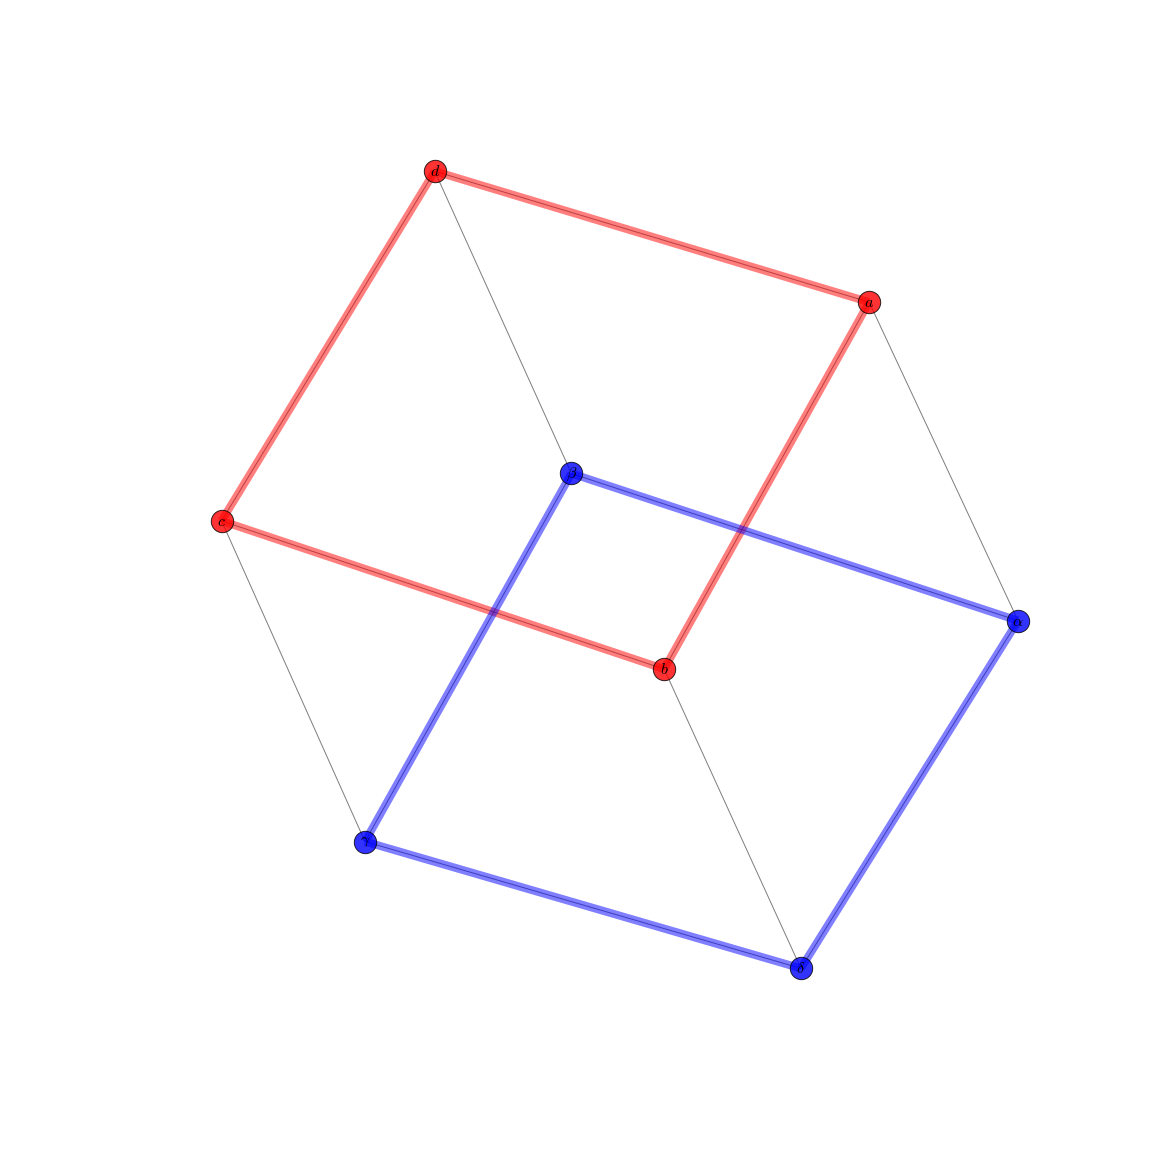

In [3]:

G=nx.cubical_graph()
pos=nx.spring_layout(G) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G,pos,
                       nodelist=[0,1,2,3],
                       node_color='r',
                       node_size=500,
                   alpha=0.8)
nx.draw_networkx_nodes(G,pos,
                       nodelist=[4,5,6,7],
                       node_color='b',
                       node_size=500,
                   alpha=0.8)

# edges
nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
nx.draw_networkx_edges(G,pos,
                       edgelist=[(0,1),(1,2),(2,3),(3,0)],
                       width=8,alpha=0.5,edge_color='r')
nx.draw_networkx_edges(G,pos,
                       edgelist=[(4,5),(5,6),(6,7),(7,4)],
                       width=8,alpha=0.5,edge_color='b')


# some math labels
labels={}
labels[0]=r'$a$'
labels[1]=r'$b$'
labels[2]=r'$c$'
labels[3]=r'$d$'
labels[4]=r'$\alpha$'
labels[5]=r'$\beta$'
labels[6]=r'$\gamma$'
labels[7]=r'$\delta$'
nx.draw_networkx_labels(G,pos,labels,font_size=16)

plt.axis('off')
plt.savefig("labels_and_colors.png") # save as png
plt.show() # display

---
<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.